<a href="https://colab.research.google.com/github/jeonghojo00/MachineLearning/blob/main/Feedback_Prize_English_Language_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Problem Definition

1. Source:
    - Kaggle Competition: Feedback Prize - Englilsh Language Learning
2. Goal:
    - To analyze
3. Files
    - 1) sample_submission.csv, 
    - 2) train.csv, 
    - 3) test.csv

2. Source

#1. Data Exploration

## 1_1. Initial Setup

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mount='/content/drive'
drive_root = mount + "/MyDrive/Colab Notebooks/NLP/feedback-prize-english-language-learning"
%cd $drive_root

/content/drive/MyDrive/Colab Notebooks/NLP/feedback-prize-english-language-learning


In [3]:
import sys
import subprocess
import pkg_resources

required = {'transformers', 'datasets', 'torchmetrics', 'contractions', 'evaluate', 'gensim', 'optuna', 'ray[tune]', 'pyspellchecker', 'imbalanced-learn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [4]:
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, f1_score
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
import imblearn

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizerFast, BertForSequenceClassification, DistilBertForSequenceClassification
from transformers import ConvBertTokenizer, ConvBertForSequenceClassification
from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig, LongformerModel
from transformers import AdamW, get_scheduler
import re, string, unicodedata
import contractions
import inflect
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords
from spellchecker import SpellChecker
import string
import re

nltk.download('stopwords')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1_2. Load Dataset

In [5]:
txtfiles = []
for file in glob.glob("./data/*.csv"):
    txtfiles.append(file)
for i, filename in enumerate(txtfiles):
    print(f"index: {i}, filename: {filename}")

index: 0, filename: ./data/sample_submission.csv
index: 1, filename: ./data/train.csv
index: 2, filename: ./data/test.csv


In [6]:
# Sample submission file
sample_df = pd.read_csv(txtfiles[0])
print("...Displaying Sample Submission")
display(sample_df)

# Train file
train_df = pd.read_csv(txtfiles[1])
print("\n...Displaying Train")
display(train_df)

# Test file
test_df = pd.read_csv(txtfiles[2])
print("\n...Displaying Test")
display(test_df)


...Displaying Sample Submission


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0



...Displaying Train


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5



...Displaying Test


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


cohesion	
syntax	
vocabulary	
phraseology	
grammar	
conventions

## 1_3. Data Analysis

### 1_3_1. Distributions

In [7]:
print(train_df['cohesion'].value_counts().sort_index())

1.0      10
1.5      27
2.0     315
2.5     790
3.0    1096
3.5     988
4.0     534
4.5     125
5.0      26
Name: cohesion, dtype: int64


In [8]:
# Cohesionn Score distribution
from collections import OrderedDict

def showDistributions(score_type='cohsion'):
    counts = dict(Counter(train_df[score_type]))
    print(f"{score_type} : {OrderedDict(sorted(counts.items()))}")
    plt.figure(figsize = (5,2))
    sns.countplot(x = train_df[score_type], palette = 'Set1', alpha = 0.8)
    plt.title(f'Distribution of {score_type} scores')
    plt.show()

cohesion : OrderedDict([(1.0, 10), (1.5, 27), (2.0, 315), (2.5, 790), (3.0, 1096), (3.5, 988), (4.0, 534), (4.5, 125), (5.0, 26)])


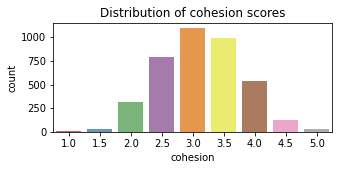

syntax : OrderedDict([(1.0, 11), (1.5, 29), (2.0, 410), (2.5, 839), (3.0, 1250), (3.5, 867), (4.0, 388), (4.5, 100), (5.0, 17)])


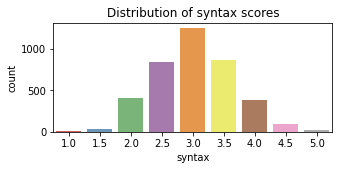

vocabulary : OrderedDict([(1.0, 2), (1.5, 14), (2.0, 124), (2.5, 528), (3.0, 1503), (3.5, 1007), (4.0, 577), (4.5, 115), (5.0, 41)])


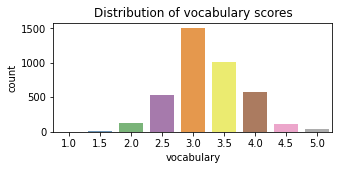

phraseology : OrderedDict([(1.0, 10), (1.5, 11), (2.0, 350), (2.5, 772), (3.0, 1153), (3.5, 929), (4.0, 553), (4.5, 108), (5.0, 25)])


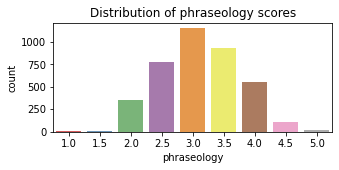

grammar : OrderedDict([(1.0, 8), (1.5, 20), (2.0, 544), (2.5, 855), (3.0, 994), (3.5, 880), (4.0, 447), (4.5, 134), (5.0, 29)])


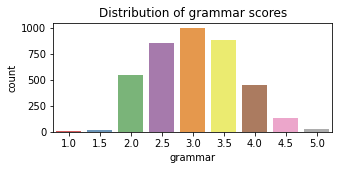

conventions : OrderedDict([(1.0, 15), (1.5, 20), (2.0, 402), (2.5, 784), (3.0, 1151), (3.5, 908), (4.0, 484), (4.5, 122), (5.0, 25)])


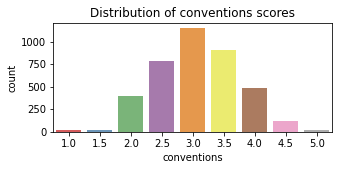

In [9]:
score_types = list(sample_df.columns)[1:]
for score_type in score_types:
    showDistributions(score_type)

### 1_3_2. Correlation

In [10]:
score_types

['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

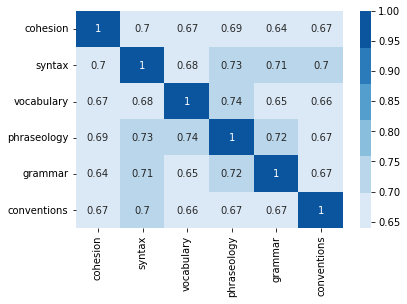

In [11]:
# Defining how required variables correlate to our target variable
corr = train_df[score_types].corr()
colormap = sns.color_palette('Blues')
sns.heatmap(corr, annot=True, cmap=colormap)

### Check misspell

In [ ]:
import re

def remove_punctuations(text):
    text = re.sub(r"[,.;@#?!&$]+\ *", " ", text)
    return text

In [ ]:
misspelled_words[2]

NameError: ignored

In [ ]:
exceptions = ['a', 'b', 'c', 'd', 'f']
spell = SpellChecker()
misspelled_words = list()
for i in range(len(example_texts)):
    a_text = example_texts[i].lower()
    a_text = remove_punctuations(a_text)
    misspelled = spell.unknown(a_text.split())
    if len(misspelled) > 0 and :
        print(f"i: {i}")
        print(a_text)
        misspelled_words.append(misspelled)

print(misspelled_words)

SyntaxError: ignored

In [ ]:


# find those words that may be misspelled
misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])

for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

NameError: ignored

In [ ]:
train_texts = train_df['full_text']
for text in train_texts:
    words = text.split()
    for word in words:
        print(spell.correction(word))

NameError: ignored

In [ ]:
train_df['full_text'][2]

"Dear, Principal\n\nIf u change the school policy of having a grade b average that unfair. Because many students have a C average. So that means that they cant go out for sports or other activities they want to do bad. That's like taking everything they have. What if kids want to become good at something, but now they cant because of that school policy. If they have a C average they should still be able to go out for sports or activities. A C average isn't that bad, its higher then a D average. If the school police was if you have a D average of lower they shouldn't do sports or activities. If they have a D average in school for not working hard, that's means that they in ain't going to try hard. If they have a C average and there trying hard they should be able to out for sports or activities. What if all the good people in sports have a C average in school, that means that they cant play and were going to lose every game we have. That's a good policy to get grade's up but don't take 

#2. Feature Engineering

## 2_1. Text Cleaning

In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Text cleaning
def cleanText(df):
    df.full_text= df.full_text.apply(lambda x:x.lower() )
    #removing square brackets
    df.full_text= df.full_text.apply(lambda x:re.sub('\[.*?\]', '', x) )
    df.full_text= df.full_text.apply(lambda x:re.sub('<.*?>+', '', x) )
    
    #removing hyperlink
    #df.text= df.text.apply(lambda x:re.sub('http[s]?://\S+|www\.\S+', '', x) )
    #df.text= df.text.apply(lambda x:replace_contractions(x))
    
    #removing puncuation
    df.full_text = df.full_text.apply(lambda x:re.sub(r"[,.;@#?!&$]+\ *", " ", x) )
    #df.text= df.text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
    #df.text= df.text.apply(lambda x:re.sub('\n' , '', x) )
    
    #remove words containing numbers
    #df.text= df.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )
    
    #remove stopwords
    df.full_text= df.full_text.apply(lambda x: remove_stopwords(x))

    return df

In [ ]:
print("Before Cleaning: ", train_df.full_text[0][:100])
print(train_df['full_text'].apply(lambda x: len(x.split(' '))).sum())
train_df = cleanText(train_df)
print(train_df['full_text'].apply(lambda x: len(x.split(' '))).sum())
print("After  Cleaning: ", train_df.full_text[0][:100])
test_df = cleanText(test_df)

Before Cleaning:  I think that students would benefit from learning at home,because they wont have to change and get u
1803481
655407
After  Cleaning:  think students benefit learning home wont change early morning shower hair taking classes helps hous


## 2_2. Creating Features

In [12]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


Use TF-IDF Vectorizer to vectorize words in a sentence

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
'''TF-IDF Vectorizer enables to reduce imporance of the most common words
so that model can penalize words by frequency so that it treats less frequent words more importantly.
Most frequent word -> Most common word -> Most meaningless word like stopwords
'''

vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf = True)
vectorizer.fit(raw_documents=train_df.full_text)

TfidfVectorizer(sublinear_tf=True)

In [14]:
def extract_vectors(x):
    vecs = vectorizer.transform(x)
    return vecs.toarray().flatten()

# extract_vectors([train.iloc[0].full_text])
train_df['vecs'] = train_df.full_text.progress_apply(lambda x: extract_vectors([x]))
test_df['vecs'] = test_df.full_text.progress_apply(lambda x: extract_vectors([x]))

100%|██████████| 3/3 [00:00<00:00, 585.31it/s]


In [15]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count


def flesch_kincaid_score(x):
    '206.835 - 1.015 × (total words ÷ total sentences) - 84.6 × (total syllables ÷ total words).'
    total_words = len(x.split())
    total_sentences = (len(x.split('.')))
    syllables = sum([syllable_count(w) for w in x.split()])
    return 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (syllables / total_words)

Flesch–Kincaid readability tests
- indicates how difficult a passage in English is to understand.
- 206.835 - 1.015 * (total words / total sentences) - 84.6 * (total syllables / total words)
- lower the harder to understand

In [16]:
# extract features from text
stop_words = stopwords.words('english')

def feature_creations(df):
    df['char_count'] = df['full_text'].progress_apply(len)
    df['word_count'] = df['full_text'].progress_apply(lambda x: len(x.split()))
    df['word_density'] = df['char_count'] / (df['word_count'] + 1)
    df['punctuation_count'] = df['full_text'].progress_apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    df['title_word_count'] = df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    df['upper_case_word_count'] = df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    df['stopword_count'] = df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))
    df['flesch_kincaid_score'] = df['full_text'].progress_apply(lambda x: flesch_kincaid_score(x))
    return df

train_df['char_count'] = train_df['full_text'].progress_apply(len)
train_df['word_count'] = train_df['full_text'].progress_apply(lambda x: len(x.split()))
train_df['word_density'] = train_df['char_count'] / (train_df['word_count'] + 1)
train_df['punctuation_count'] = train_df['full_text'].progress_apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train_df['title_word_count'] = train_df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train_df['upper_case_word_count'] = train_df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
train_df['stopword_count'] = train_df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))
train_df['flesch_kincaid_score'] = train_df['full_text'].progress_apply(lambda x: flesch_kincaid_score(x))

100%|██████████| 3911/3911 [00:02<00:00, 1495.94it/s]


In [17]:
test_df = feature_creations(test_df)

100%|██████████| 3/3 [00:00<00:00, 953.97it/s]


In [18]:
eng_features = train_df.drop(['text_id', 'full_text', 'cohesion','syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'vecs'], axis=1).columns

In [19]:
# Normalize X
from sklearn.preprocessing import StandardScaler
scaled_train_df = train_df.copy()
scaled_test_df = test_df.copy()

scaler = StandardScaler()
scaled_train_df[list(eng_features)] = scaler.fit_transform(scaled_train_df[list(eng_features)])
scaled_test_df[list(eng_features)] = scaler.transform(scaled_test_df[list(eng_features)])

In [20]:
# Flatten Each Row
def flattenRows(df):
    '''
    Make a X dataset combining a list of word vectors and other infomrative features such as 
    char counts, word counts, ..., and flesch_kincaid_score.
    '''
    features_set = []

    for index, row in tqdm(df.iterrows(), total=len(df)):
        text_vecs = row['vecs']
        other_features = row[eng_features].values.astype(float)
        features_set.append(np.append(text_vecs, other_features))

    X = np.array(features_set)   
    return X

In [21]:
scaled_X = flattenRows(scaled_train_df)
X = flattenRows(train_df)
scaled_test_X = flattenRows(scaled_test_df)

100%|██████████| 3/3 [00:00<00:00, 1308.95it/s]


In [22]:
scores = {}
for score_type in score_types:
    scores[score_type] = train_df[score_type].values

In [23]:
scores

{'cohesion': array([3.5, 2.5, 3. , ..., 2.5, 4. , 3.5]),
 'syntax': array([3.5, 2.5, 3.5, ..., 3. , 4.5, 2.5]),
 'vocabulary': array([3. , 3. , 3. , ..., 3. , 4.5, 3.5]),
 'phraseology': array([3., 2., 3., ..., 3., 4., 3.]),
 'grammar': array([4. , 2. , 3. , ..., 3.5, 4.5, 3. ]),
 'conventions': array([3. , 2.5, 2.5, ..., 3. , 4.5, 3.5])}

#3. Modeling
- The problem is the predict appropraite scores from 1.0 to 5.5 with 0.5 increment for score types
- Classification and regression will be considered
- For each classification and regression, multioutput or single outputx6 will be experimented

In [24]:
def showDisributions(data, title=None):
    counts = dict(Counter(data))
    print(f"Data counts : {OrderedDict(sorted(counts.items()))}")
    plt.figure(figsize = (5,2))
    sns.countplot(x = data, palette = 'Set1', alpha = 0.8)
    plt.title(f'{title} Distributions')
    plt.show()    

## 3_1. Regressions

### 3_1_1. Find Optimal Parameters for LGBM Regressor

In [25]:
from lightgbm import LGBMRegressor, LGBMClassifier
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
from sklearn.metrics import f1_score, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from statistics import mean
import pickle

rmse_scorer = make_scorer(mean_squared_error , squared=False)

test_params ={'boosting_type': ['gbdt', 'dart'],
             'num_leaves': [30, 100, 200], 
             'max_depth' : [5, 7, 10, 15],
             'learning_rate' : [0.1, 0.05, 0.01],
             'n_estimators': [1000, 5000],
             'subsample': [0.5, 0.7, 1.0], 
             'colsample_bytree': [0.5, 0.7, 1.0],
             'reg_alpha': [0, 1e-1, 5e-1, 1, 10],
             'reg_lambda': [0, 1e-1, 5e-1, 1, 10]}


#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

In [27]:
new_dict

{'cohesion': {'subsample': 0.5,
  'reg_lambda': 10,
  'reg_alpha': 1,
  'num_leaves': 30,
  'n_estimators': 5000,
  'max_depth': 15,
  'learning_rate': 0.05,
  'colsample_bytree': 1.0,
  'boosting_type': 'dart'},
 'syntax': {'subsample': 0.7,
  'reg_lambda': 0.5,
  'reg_alpha': 10,
  'num_leaves': 100,
  'n_estimators': 5000,
  'max_depth': 15,
  'learning_rate': 0.1,
  'colsample_bytree': 0.5,
  'boosting_type': 'dart'},
 'vocabulary': {'subsample': 0.7,
  'reg_lambda': 0.1,
  'reg_alpha': 10,
  'num_leaves': 30,
  'n_estimators': 5000,
  'max_depth': 10,
  'learning_rate': 0.1,
  'colsample_bytree': 0.7,
  'boosting_type': 'dart'}}

In [ ]:
lgbmReg_optim = dict()
rmse_scores = list()
file2save = 'rmse_'+str(np.mean(rmse_scores).item())+'_LGBMRegressor_optim_params.pkl'

for score_type in tqdm(score_types):
    model = LGBMRegressor(random_state=42, n_jobs=-1)
    cv= KFold(n_splits=5, shuffle=True, random_state=42)
    gs = RandomizedSearchCV(
        estimator=model, 
        param_distributions=test_params, 
        n_iter=n_HP_points_to_test,
        scoring=rmse_scorer,
        cv=cv,
        refit=True,
        verbose=1)

    gs.fit(scaled_X, scores[score_type])
    print('{}: Best score reached: {} with params: {} '.format(score_type, gs.best_score_, gs.best_params_))
    lgbmReg_optim[score_type] = gs.best_params_
    rmse_scores.append(gs.best_score_)

    # create a binary pickle file 
    f = open(file2save,"wb")
    pickle.dump(lgbmReg_optim,f)
    print(f'{file2save} saved')
    f.close()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/6 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


 17%|█▋        | 1/6 [6:25:51<32:09:17, 23151.43s/it]

cohesion: Best score reached: 3.2937436929293553 with params: {'subsample': 0.5, 'reg_lambda': 10, 'reg_alpha': 1, 'num_leaves': 30, 'n_estimators': 5000, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'boosting_type': 'dart'} 
rmse_nan_LGBMRegressor_optim_params.pkl saved
Fitting 5 folds for each of 100 candidates, totalling 500 fits


 33%|███▎      | 2/6 [11:50:15<23:18:49, 20982.31s/it]

syntax: Best score reached: 3.080429522324505 with params: {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 10, 'num_leaves': 100, 'n_estimators': 5000, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'boosting_type': 'dart'} 
rmse_nan_LGBMRegressor_optim_params.pkl saved
Fitting 5 folds for each of 100 candidates, totalling 500 fits


 50%|█████     | 3/6 [16:41:39<16:09:14, 19384.78s/it]

vocabulary: Best score reached: 3.415112626453886 with params: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 10, 'num_leaves': 30, 'n_estimators': 5000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'boosting_type': 'dart'} 
rmse_nan_LGBMRegressor_optim_params.pkl saved
Fitting 5 folds for each of 100 candidates, totalling 500 fits


### 3_1_2. Train and predict

In [33]:
filename = 'rmse_nan_LGBMRegressor_optim_params.pkl'
infile = open(filename,'rb')
lgbmReg_params = pickle.load(infile)
infile.close()

In [28]:
def evaluate_model(model, X, y, cv, flag='regression'):
    results = dict()    
    if flag == 'regression':
        mae = cross_val_score(model, X, y, cv = cv, scoring='neg_mean_absolute_error')
        mse = cross_val_score(model, X, y, cv = cv, scoring='neg_mean_squared_error')
        rmse = cross_val_score(model, X, y, cv = cv, scoring='neg_root_mean_squared_error')
        r2 = cross_val_score(model, X, y, cv = cv, scoring='r2')
        results['MAE'] = abs(np.mean(mae))
        results['MSE'] = abs(np.mean(mse))
        results['RMSE'] = abs(np.mean(rmse))
        results['R2'] = abs(np.mean(r2))
    else:
        f1 = cross_val_score(model, X, y, cv = cv, scoring='f1_weighted')
        roc_auc = cross_val_score(model, X, y, cv = cv, scoring='roc_auc_ovo_weighted')
        results['f1'] = abs(np.mean(f1))
        results['ROC_AUC'] = abs(np.mean(roc_auc))
    return results

In [34]:
score_type = 'cohesion'
optim_param = lgbmReg_params[score_type]
model = LGBMRegressor(**optim_param)
cv= KFold(n_splits=5, shuffle=True)
eval_results = evaluate_model(model, scaled_X, scores[score_type], cv, flag='regression')
display(eval_results)

{'MAE': 3.462863367944462,
 'MSE': 11.441278628585891,
 'RMSE': 3.264097760437277,
 'R2': 28.10810283383409}

In [ ]:
score_type = 'cohesion'
model = LGBMRegressor()
cv= KFold(n_splits=5, shuffle=True)
eval_results = evaluate_model(model, scaled_X, scores[score_type], cv, flag='regression')
display(eval_results)

{'MAE': 0.4504556952342148,
 'MSE': 0.3060366702769185,
 'RMSE': 0.5480434278172966,
 'R2': 0.3030241128201774}

In [ ]:
score_type = 'cohesion'
model = LGBMRegressor()
cv= KFold(n_splits=5, shuffle=True)
eval_results = evaluate_model(model, X, scores[score_type], cv, flag='regression')
display(eval_results)

{'MAE': 0.4455762179590995,
 'MSE': 0.3045563447311723,
 'RMSE': 0.5549702606347953,
 'R2': 0.30146783006933536}

In [ ]:
LGBM_results = dict()
LGBM_results['regression'] = dict()

In [ ]:
# LGBM Regression
for score_type in score_types:
    model = LGBMRegressor()
    cv= KFold(n_splits=5, shuffle=True)
    LGBM_results['regression'][score_type] = evaluate_model(model, X, scores[score_type], cv, 'regression')

display(LGBM_results)

In [ ]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, scores['cohesion'], test_size=0.2, random_state=42)
lgbmReg = LGBMRegressor()
lgbmReg.fit(X_train, y_train)
y_pred = lgbmReg.predict(X_test)

In [ ]:
def round_to_scale(predictions):
    rounded = list()
    for val in predictions:
        if val < 1.25:
            rounded.append(1.0)
        elif val < 1.75:
            rounded.append(1.5)
        elif val < 2.25:
            rounded.append(2.0)
        elif val < 2.75:
            rounded.append(2.5)
        elif val < 3.25:
            rounded.append(3.0)
        elif val < 3.75:
            rounded.append(3.5)
        elif val < 4.25:
            rounded.append(4.0)
        elif val < 4.75:
            rounded.append(4.5)
        else:
            rounded.append(5.0)
    return np.array(rounded)


In [ ]:
rounded_y = round_to_scale(y_pred)

In [ ]:
mean_squared_error(y_test, y_pred, squared=False)

0.5440929703972038

cohesion	
syntax	
vocabulary	
phraseology	
grammar	
conventions

In [31]:
test_df

,text_id,full_text,vecs,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count,flesch_kincaid_score
0,0000C359D63E,when a person has no experience on a job their...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4224,835,5.052632,37,25,1,454,67.346130
1,000BAD50D026,Do you think students would benefit from being...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2167,386,5.599483,36,11,1,207,67.940871
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2361,442,5.329571,33,11,1,244,62.349525


In [35]:
for score_type in score_types:
    model = LGBMRegressor()
    model.fit(scaled_X, scores[score_type])
    test_df[score_type] = model.predict(scaled_test_X)

In [36]:
test_df

,text_id,full_text,vecs,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count,flesch_kincaid_score,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4224,835,5.052632,37,25,1,454,67.346130,3.257816,3.053141,3.416932,3.264194,2.924972,2.966888
1,000BAD50D026,Do you think students would benefit from being...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2167,386,5.599483,36,11,1,207,67.940871,2.946341,3.039620,2.993347,2.734318,2.746865,3.140122
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2361,442,5.329571,33,11,1,244,62.349525,3.577981,3.268005,3.358719,3.285543,3.405709,3.122653


In [40]:
submission_cols = ['text_id'] + score_types
submission = test_df[submission_cols]
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.257816,3.053141,3.416932,3.264194,2.924972,2.966888
1,000BAD50D026,2.946341,3.039620,2.993347,2.734318,2.746865,3.140122
2,00367BB2546B,3.577981,3.268005,3.358719,3.285543,3.405709,3.122653


In [37]:
sample_df

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [41]:
submission.to_csv("submission.csv", index=False)

## 3_2. Classification

In [ ]:
# Apply Label encoder for scores for Classification
label_encoders = dict()
scores4clf = dict()
for score_type in score_types:
    label_encoders[score_type] = LabelEncoder()
    train_df[score_type+'_le'] = label_encoders['cohesion'].fit_transform(train_df[score_type])
    scores4clf[score_type] = train_df[score_type+'_le']

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, scores4clf['cohesion'], test_size=0.2, random_state=42)

# Oversample for train data for imbalanced status
oversample = RandomOverSampler()
X_train_ros, y_train_ros = oversample.fit_resample(X_train, y_train)

y_train_counts = dict(Counter(y_train))
print(y_train_counts)

{6: 431, 5: 769, 2: 253, 4: 881, 3: 639, 7: 106, 8: 21, 1: 20, 0: 8}


Data counts : OrderedDict([(0, 8), (1, 20), (2, 253), (3, 639), (4, 881), (5, 769), (6, 431), (7, 106), (8, 21)])


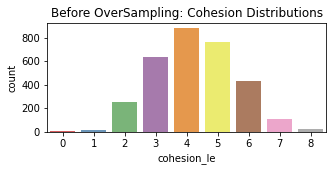

Data counts : OrderedDict([(0, 881), (1, 881), (2, 881), (3, 881), (4, 881), (5, 881), (6, 881), (7, 881), (8, 881)])


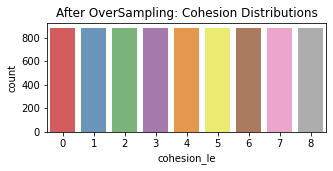

In [ ]:
showDisributions(y_train, title='Before OverSampling: Cohesion')
showDisributions(y_train_ros, title='After OverSampling: Cohesion')

## 3_2_1. Find Optimal Parameters for LGBM classifier

Data counts : OrderedDict([(0, 2), (1, 7), (2, 62), (3, 151), (4, 215), (5, 219), (6, 103), (7, 19), (8, 5)])


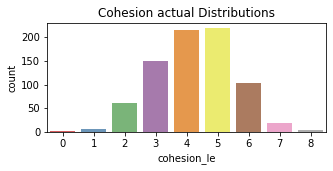

Data counts : OrderedDict([(0, 1), (1, 8), (2, 25), (3, 143), (4, 269), (5, 241), (6, 86), (7, 6), (8, 4)])


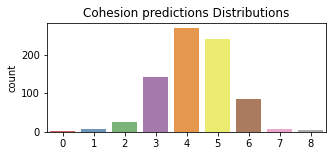

0.2614478446427929


In [ ]:
model = LGBMClassifier()
model.fit(X_train_ros, y_train_ros)
y_pred = model.predict(X_test)
#y_pred = label_encoders['cohesion'].inverse_transform(y_pred)

showDisributions(y_test, title='Cohesion actual')
showDisributions(y_pred, title='Cohesion predictions')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

In [ ]:
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
from sklearn.metrics import f1_score, make_scorer

def evaluate_weightedF1_lgb(truth, predictions):
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    return "weightedF1", f1, True

f1_scorer = make_scorer(f1_score , average='weighted')

param_test ={'boosting_type': ['gbdt', 'rf'],
             'num_leaves': sp_randInt(6, 50), 
             'max_depth' : [-1],
             'learning_rate' : sp_randFloat(),
             'n_estimators': [1000, 5000],
             'objective': ['multiclass'], #'multiclass for multi-class classificaiton
             'min_child_samples': sp_randInt(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_randFloat(), 
             'colsample_bytree': sp_randFloat(),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

clf = LGBMClassifier(class_weight = y_train_counts,
                     random_state=42, 
                     n_jobs=-1)
cv= KFold(n_splits=5, shuffle=True, random_state=42)
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring=f1_scorer,
    cv=cv,
    refit=True,
    random_state=42,
    verbose=True)

In [ ]:
gs.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
220 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
220 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 744, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 544, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    bo

Best score reached: 0.29658998049052604 with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.5527649668354899, 'learning_rate': 0.5722924691708383, 'max_depth': -1, 'min_child_samples': 287, 'min_child_weight': 1e-05, 'n_estimators': 5000, 'num_leaves': 26, 'objective': 'multiclass', 'reg_alpha': 10, 'reg_lambda': 0, 'subsample': 0.31692200515627766} 


In [ ]:
lgbmClf_params = dict()
lgbmClf_params['cohesion'] = {'boosting_type': 'gbdt', 
                              'colsample_bytree': 0.5527649668354899, 
                              'learning_rate': 0.5722924691708383, 
                              'max_depth': -1, 'min_child_samples': 287, 
                              'min_child_weight': 1e-05, 
                              'n_estimators': 5000, 
                              'num_leaves': 26, 
                              'objective': 'multiclass', 
                              'reg_alpha': 10, 
                              'reg_lambda': 0, 
                              'subsample': 0.31692200515627766}

Data counts : OrderedDict([(0, 2), (1, 7), (2, 62), (3, 151), (4, 215), (5, 219), (6, 103), (7, 19), (8, 5)])


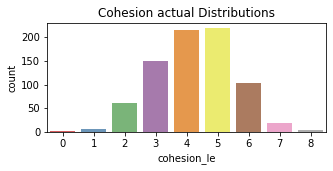

Data counts : OrderedDict([(1, 1), (2, 35), (3, 161), (4, 257), (5, 234), (6, 88), (7, 7)])


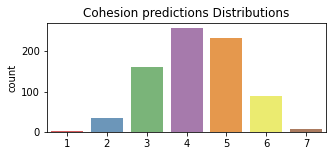

Cohesion f1 score:  0.2631418493209135


In [ ]:
model = LGBMClassifier(**lgbmClf_params['cohesion'])
model.fit(X_train_ros, y_train_ros)
y_pred = model.predict(X_test)
#y_pred = label_encoders['cohesion'].inverse_transform(y_pred)

showDisributions(y_test, title='Cohesion actual')
showDisributions(y_pred, title='Cohesion predictions')

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Cohesion f1 score: ", f1)